In [5]:
import xarray as xa
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import lib.atmosphere as atm
import lib.physics as phy

In [2]:
fds = xa.open_dataset('./forcings/southern_nz_6a_icar-095_erai_165,176,-48,-40_30-04-2015-to-01-06-2015.nc')

In [77]:
Nx = fds.west_east.shape[0]
Ny = fds.south_north.shape[0]
Nz = fds.bottom_top.shape[0]
Nt = fds.Time.shape[0]

fds

<xarray.Dataset>
Dimensions:      (Time: 136, bottom_top: 60, south_north: 14, west_east: 18)
Coordinates:
  * Time         (Time) datetime64[ns] 2015-04-30 ... 2015-06-02T18:00:00
  * bottom_top   (bottom_top) int32 0 1 2 3 4 5 6 7 ... 52 53 54 55 56 57 58 59
  * west_east    (west_east) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
  * south_north  (south_north) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Data variables:
    XLONG        (Time, south_north, west_east) float64 ...
    XLAT         (Time, south_north, west_east) float64 ...
    HGT          (Time, south_north, west_east) float32 ...
    U            (Time, bottom_top, south_north, west_east) float32 ...
    V            (Time, bottom_top, south_north, west_east) float32 ...
    TH           (Time, bottom_top, south_north, west_east) float64 ...
    P            (Time, bottom_top, south_north, west_east) float64 ...
    PB           (Time, bottom_top, south_north, west_east) float64 ...
    PH           (Time, bottom_top,

In [13]:
nx = 9
ny = 7
nt = 5

In [25]:
N_arr = np.zeros(Nt*Nz*Ny*Nx).reshape(Nt,Nz,Ny,Nx)

In [32]:
N_min = 1*10**-7
N_max = 6*10**-4

for nt in range(1):
    for nx in range(Nx):
        for ny in range(Ny):
            z_arr = fds.PH[nt,:,ny,nx]
            th_arr = fds.TH[nt,:,ny,nx]
            for n, z in enumerate(z_arr):
                if n < len(z_arr)-1:
                    lth1 = np.log(th_arr[n+1])
                    lth0 = np.log(th_arr[n])
                    dlth = lth1-lth0
                    dz   = z_arr[n+1]-z_arr[n]
                    frac = dlth/dz
                    
                    if frac < 0:
                        N   = N_min
                    else:
                        N   = np.sqrt(9.81*(frac))

                    if N < N_min:
                        N = N_min
                    elif N > N_max:
                        N = N_max
                    
                    N_arr[nt,n,ny,nx] = N
                                      
            N_arr[nt,-1,ny,nx] = N_arr[nt,-2,ny,nx]

KeyboardInterrupt: 

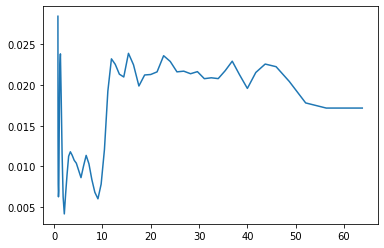

In [23]:
plt.plot(z_arr/1000,N_arr)

In [47]:
N_arr = np.zeros(Nt*Nz*Ny*Nx).reshape(Nt,Nz,Ny,Nx)

In [76]:
N_min = np.sqrt(1*10**-7)
N_max = np.sqrt(6*10**-4)

for nt in range(Nt):
    if nt%10 == 0:
        print('timestep {:n}/{:n}'.format(nt,Nt))
    
    for nx in range(Nx):
        for ny in range(Ny):
            z_arr = fds.PH[nt,:,ny,nx].values
            th_arr = fds.TH[nt,:,ny,nx].values
            
            lth1 = np.log(th_arr[1:])
            lth0 = np.log(th_arr[:-1])
            dlth = lth1-lth0
            dz   = z_arr[1:]-z_arr[:-1]
            frac      = np.zeros(Nz)
            frac[:-1] = dlth/dz
            frac[-1]  = frac[-2]

            N_arr[nt,:,ny,nx][frac<0]=N_min
            N_arr[nt,:,ny,nx][frac>=0]=np.sqrt(9.81*(frac[frac>=0]))
            N_arr[nt,:,ny,nx][N_arr[nt,:,ny,nx]<N_min] = N_min
            N_arr[nt,:,ny,nx][N_arr[nt,:,ny,nx]>N_max] = N_max

timestep 0/136
timestep 10/136
timestep 20/136
timestep 30/136
timestep 40/136
timestep 50/136
timestep 60/136
timestep 70/136


KeyboardInterrupt: 

In [62]:
frac.shape

(60,)

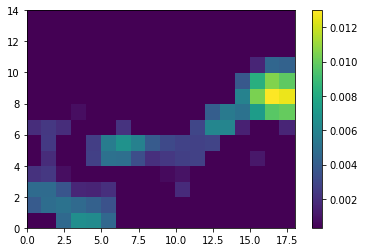

In [72]:
plt.pcolormesh(N_arr[0,5,:])
plt.colorbar()

In [ ]:
plt.pcolormesh()